In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import make_scorer

from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
train = pd.read_csv('bike-sharing-demand/train.csv')
test = pd.read_csv('bike-sharing-demand/test.csv')
sub = pd.read_csv('bike-sharing-demand/sampleSubmission.csv')

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
test.isnull().sum()
# 따로 결측은 없음 -> 하지만 있을 수도 있으므로 체크하기

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [8]:
train.datetime = pd.to_datetime(train.datetime)

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

In [9]:
test.datetime = pd.to_datetime(test.datetime)

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour

In [15]:
train.dtypes

dtype('int64')

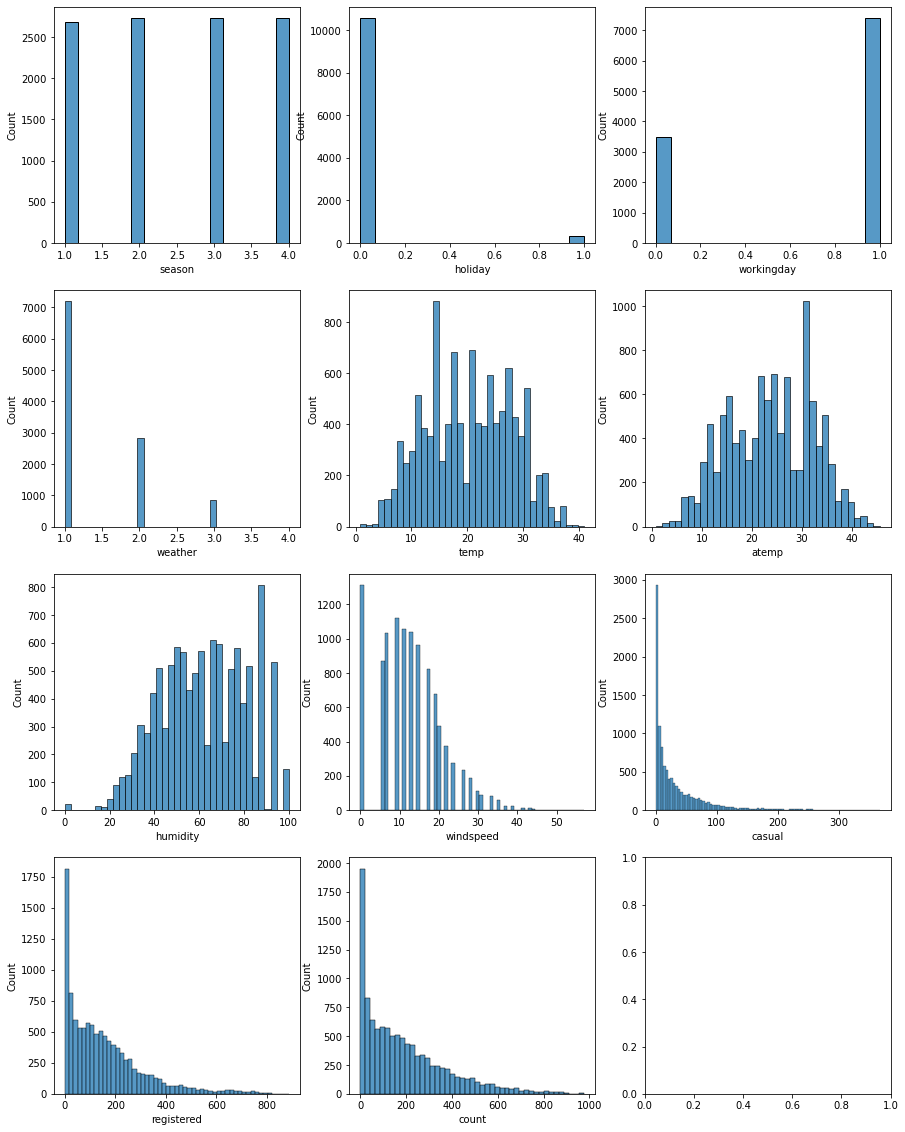

In [11]:
f, axes = plt.subplots(4,3,figsize=(15,20))

k = 1

for i in range(0,4) :
    for j in range(0,3) :
        sns.histplot(train.iloc[:,k], ax = axes[i,j]) # histplot으로 그리는게 훨씬 깔쌈!
        k+=1
        if k==12 : break
            
        

In [ ]:
'''holiday가 아닌 경우가 훨씬 많고, working day가 훨씬 많고, 계절 별로는 거의 다 있고, temp : 거의 고른듯?
    풍속이 0 인 경우가 눈에 띔(띄어야함,,ㅎ)
    casual은 굉장히 치우친 분포를 보임
    resistered는 -> target 인데 치우친 분포가 있는 것같음 -> log 변환 후 다시 exp 씌우는 것도 괜찮을 듯 (하다고 생각해야함)'''

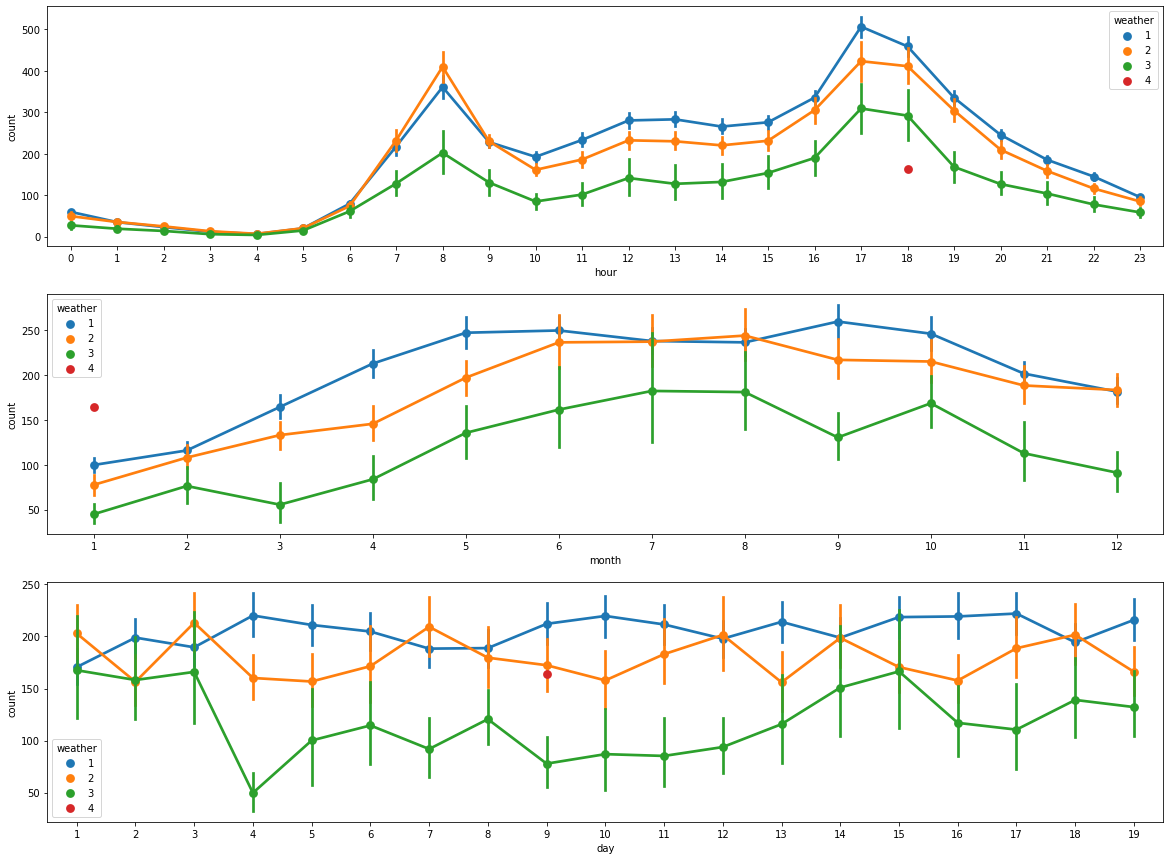

In [15]:
fig, ax1 = plt.subplots(3,1)
fig.set_size_inches(20, 15)

sns.pointplot(data = train, x='hour', y = 'count', hue='weather', ax = ax1[0]) # 시간에 따른 변화가 뚜렷함
sns.pointplot(data = train, x='month', y = 'count', hue='weather', ax = ax1[1])
sns.pointplot(data = train, x='day', y = 'count', hue='weather', ax = ax1[2])

plt.show()

In [54]:
train.groupby(['month','weather']).count()
# 1월에는 1이 절대 다수로 많음 => but test 데이터에도 같은 패턴의 데이터 있으므로 그대로 두기

datetime  season  holiday  workingday  temp  atemp  humidity  \
month weather                                                                 
1     1             592     592      592         592   592    592       592   
      2             231     231      231         231   231    231       231   
      3              60      60       60          60    60     60        60   
      4               1       1        1           1     1      1         1   
2     1             576     576      576         576   576    576       576   
      2             237     237      237         237   237    237       237   
      3              88      88       88          88    88     88        88   
3     1             591     591      591         591   591    591       591   
      2             247     247      247         247   247    247       247   
      3              63      63       63          63    63     63        63   
4     1             592     592      592         592   592    592       592   
      2             241     241      241         241   241    241       241   
      3              76      76       76          76    76     76        76   
5     1             528     528      528         528   528    528       528   
      2             287     287      287         287   287    287       287   
      3              97      97       97          97    97     97        97   
6     1             681     681      681         681   681    681       681   
      2             180     180      180         180   180    180       180   
      3              51      51       51          51    51     51        51   
7     1             718     718      718         718   718    718       718   
      2             155     155      155         155   155    155       155   
      3              39      39       39          39    39     39        39   
8     1             654     654      654         654   654    654       654   
      2             195     195      195         195   195    195       195   
      3              63      63       63          63    63     63        63   
9     1             558     558      558         558   558    558       558   
      2             254     254      254         254   254    254       254   
      3              97      97       97          97    97     97        97   
10    1             543     543      543         543   543    543       543   
      2             255     255      255         255   255    255       255   
      3             113     113      113         113   113    113       113   
11    1             630     630      630         630   630    630       630   
      2             235     235      235         235   235    235       235   
      3              46      46       46          46    46     46        46   
12    1             529     529      529         529   529    529       529   
      2             317     317      317         317   317    317       317   
      3              66      66       66          66    66     66        66   

               windspeed  casual  registered  count  year  day  hour  
month weather                                                         
1     1              592     592         592    592   592  592   592  
      2              231     231         231    231   231  231   231  
      3               60      60          60     60    60   60    60  
      4                1       1           1      1     1    1     1  
2     1              576     576         576    576   576  576   576  
      2              237     237         237    237   237  237   237  
      3               88      88          88     88    88   88    88  
3     1              591     591         591    591   591  591   591  
      2              247     247         247    247   247  247   247  
      3               63      63          63     63    63   63    63  
4     1              592     592         592    592   592  592   592  
      2   

In [55]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157,2011.503619,6.565070,25.224550,11.555367
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151,0.500025,3.429462,3.339411,6.912526
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000,2011.000000,1.000000,20.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500,2011.000000,4.000000,22.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400,2012.000000,7.000000,25.000000,12.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900,2012.000000,10.000000,28.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600,2012.000000,12.000000,31.000000,23.000000


In [56]:
test.groupby(['month', 'weather']).count()

datetime  season  holiday  workingday  temp  atemp  humidity  \
month weather                                                                 
1     1             298     298      298         298   298    298       298   
      2             197     197      197         197   197    197       197   
      3              48      48       48          48    48     48        48   
      4               2       2        2           2     2      2         2   
2     1             286     286      286         286   286    286       286   
      2             105     105      105         105   105    105       105   
      3              49      49       49          49    49     49        49   
3     1             312     312      312         312   312    312       312   
      2             194     194      194         194   194    194       194   
      3              66      66       66          66    66     66        66   
4     1             331     331      331         331   331    331       331   
      2             131     131      131         131   131    131       131   
      3              66      66       66          66    66     66        66   
5     1             416     416      416         416   416    416       416   
      2             114     114      114         114   114    114       114   
      3              46      46       46          46    46     46        46   
6     1             412     412      412         412   412    412       412   
      2              95      95       95          95    95     95        95   
      3              21      21       21          21    21     21        21   
7     1             454     454      454         454   454    454       454   
      2              99      99       99          99    99     99        99   
      3              23      23       23          23    23     23        23   
8     1             432     432      432         432   432    432       432   
      2             107     107      107         107   107    107       107   
      3              24      24       24          24    24     24        24   
9     1             321     321      321         321   321    321       321   
      2             160     160      160         160   160    160       160   
      3              47      47       47          47    47     47        47   
10    1             332     332      332         332   332    332       332   
      2             157     157      157         157   157    157       157   
      3              51      51       51          51    51     51        51   
11    1             328     328      328         328   328    328       328   
      2             143     143      143         143   143    143       143   
      3              55      55       55          55    55     55        55   
12    1             299     299      299         299   299    299       299   
      2             208     208      208         208   208    208       208   
      3              64      64       64          64    64     64        64   

               windspeed  year  day  hour  
month weather                              
1     1              298   298  298   298  
      2              197   197  197   197  
      3               48    48   48    48  
      4                2     2    2     2  
2     1              286   286  286   286  
      2              105   105  105   105  
      3               49    49   49    49  
3     1              312   312  312   312  
      2              194   194  194   194  
      3               66    66   66    66  
4     1              331   331  331   331  
      2              131   131  131   131  
      3               66    66   66    66  
5     1              416   416  416   416  
      2              114   114  114   114  
      3               46    46   46    46  
6     1              412   412  412   412  
      2               95    95   95    95  
      3               21    21   21    21  
7     1  

<AxesSubplot:>

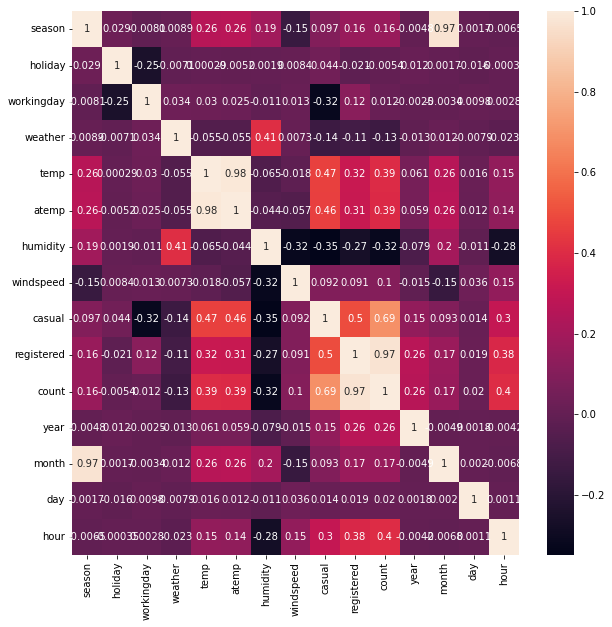

In [16]:
f, ax = plt.subplots(1,1, figsize = (10,10))
sns.heatmap(train.corr(), annot=True)
# 온도와 체감 온도는 매우 높은 상관관계를 가짐 -> 하나만 사용해도 될 것같은데? -> atemp만 남기기로 (해석이 이게 더 용이함)
# month와 season도 높은 상관관계를 보임

In [62]:
train.drop(['temp'], axis = 1, inplace = True)
test.drop(['temp'], axis = 1, inplace = True)

<AxesSubplot:xlabel='windspeed', ylabel='Count'>

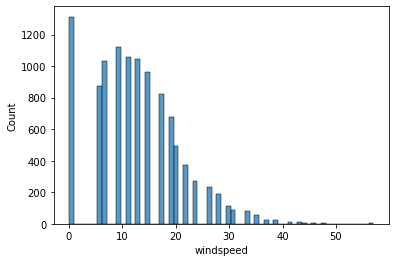

In [17]:
sns.histplot(train.windspeed)
# 풍속이 0인 데이터가 굉장히 많음

In [18]:
# 중앙값으로 대체하기
wind = train.windspeed.mode()[0]
train.loc[train['windspeed']==0, 'windspeed'] = wind
test.loc[test['windspeed']==0, 'windspeed'] = wind

<AxesSubplot:xlabel='humidity', ylabel='Count'>

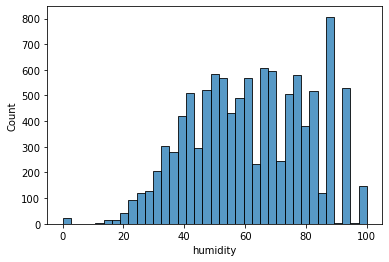

In [99]:
sns.histplot(train.humidity)
# 같은 방식으로 humidity도 적용

In [101]:
train.loc[train.humidity == 0,:] # 다 같은 날임 -> 결측으로 보는게 맞을듯

,datetime,season,holiday,workingday,weather,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
1091,2011-03-10 00:00:00,1,0,1,3,15.910,0,16.9979,3,0,3,2011,3,10,0
1092,2011-03-10 01:00:00,1,0,1,3,15.910,0,16.9979,0,2,2,2011,3,10,1
1093,2011-03-10 02:00:00,1,0,1,3,15.910,0,16.9979,0,1,1,2011,3,10,2
1094,2011-03-10 05:00:00,1,0,1,3,17.425,0,12.9980,1,2,3,2011,3,10,5
1095,2011-03-10 06:00:00,1,0,1,3,16.665,0,22.0028,0,12,12,2011,3,10,6
1096,2011-03-10 07:00:00,1,0,1,3,19.695,0,15.0013,1,36,37,2011,3,10,7
1097,2011-03-10 08:00:00,1,0,1,3,19.695,0,19.0012,1,43,44,2011,3,10,8
1098,2011-03-10 09:00:00,1,0,1,3,20.455,0,15.0013,1,23,24,2011,3,10,9
1099,2011-03-10 10:00:00,1,0,1,3,20.455,0,11.0014,0,17,17,2011,3,10,10
1100,2011-03-10 11:00:00,1,0,1,3,20.455,0,16.9979,6,5,11,2011,3,10,11


In [19]:
humid = train.humidity.mode()[0]
train.loc[train['humidity']==0,'humidity'] = humid
test.loc[test['humidity'] == 0, 'humidity'] = humid

In [21]:
scaler = StandardScaler()

In [22]:
X = train.drop(['datetime', 'casual', 'registered', 'count'], axis = 1)
col_list = X.columns
y = train['count']

scaler.fit(X)

X = pd.DataFrame(scaler.transform(X), columns = col_list)

<AxesSubplot:xlabel='count', ylabel='Count'>

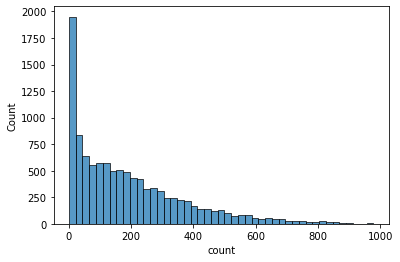

In [23]:
sns.histplot(y)
# y가 매우 치우친 형태로 되어있으므로 -> log 변환을 고려할 수 있음
# 대신에 => 최종 제출 데이터를 만들때는 무조건 다시 exp 취해서 되돌려놔야함...!!

In [44]:
def RMSLE(y_pred, y_test) :
    y_pred = np.array(y_pred)
    y_test = np.array(y_test)
    
    result = np.sqrt(((np.log(y_pred+1) - np.log(y_test+1))**2).mean())
    
    return result
    
score_rmsle = make_scorer(RMSLE, greater_is_better = False)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

y_train = np.log(y_train)

benchmark = pd.DataFrame(columns = ['Algorithm', 'mae', 'mape', 'rmse', 'rmsle', 'r2'])

for algorithm in [LinearRegression(), RandomForestRegressor(random_state = 30, max_depth = 5), 
                  AdaBoostRegressor(random_state = 42), XGBRegressor(n_estimators = 100)] :
    
    pipeline = Pipeline([['regressor', algorithm]])
    
    result_ = GridSearchCV(estimator = pipeline,
                           scoring = score_rmsle,
                           param_grid = {},
                           cv = None,
                           n_jobs = -1)
    result_.fit(X_train, y_train)
    pred = np.exp(result_.predict(X_test))
    mae = mean_absolute_error(pred, y_test)
    mape = mean_absolute_percentage_error(pred, y_test)
    rmse = mean_squared_error(pred,y_test)
    rmsle = RMSLE(pred, y_test)
    r2 = r2_score(pred, y_test)
    
    benchmark = benchmark.append({'Algorithm':algorithm, 'mae':mae, 'mape':mape, 'rmse':rmse, 'rmsle':rmsle, 'r2':r2}, ignore_index = True)
    
benchmark

,Algorithm,mae,mape,rmse,rmsle,r2
0,LinearRegression(),108.462685,1.132861,26112.244268,1.024040,-0.277911
1,"RandomForestRegressor(max_depth=5, random_stat...",68.383710,0.460391,12754.930736,0.550065,0.042859
2,AdaBoostRegressor(random_state=42),86.538774,0.813631,20957.459070,0.672644,-1.707999
3,"XGBRegressor(base_score=None, booster=None, ca...",27.505632,0.239732,1874.862751,0.313001,0.941860


<AxesSubplot:xlabel='count', ylabel='Count'>

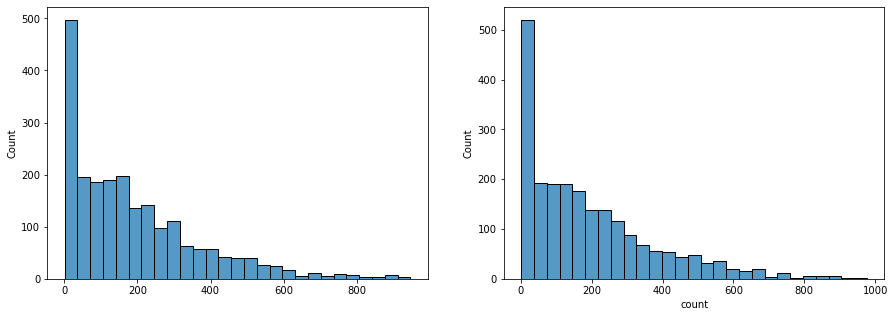

In [49]:
f, axes = plt.subplots(1,2, figsize = (15,5))

sns.histplot(pred, ax = axes[0])
sns.histplot(y_test, ax = axes[1])

In [55]:
min_ = 1000
seed = 0
m_dp = 0
n_esti = 0

for i in range(3,10,3) :
    for j in range(50,200,50) :
        #for k in range(10,100,10) :
        model_xgb = XGBRegressor(max_depth = i, n_estimators = j)#, learning_rate = k)
        model_xgb.fit(X_train, y_train)
        y_pred = model_xgb.predict(X_test)
        y_pred = np.exp(y_pred)
        rate = RMSLE(y_pred, y_test)
        if min_ > rate :
            min_ = r2
            #seed = k
            m_dp = i
            n_esti = j

                
model_xgb = XGBRegressor(max_depth = m_dp, n_estimators = n_esti) # , learning_rate = seed)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
y_pred = np.exp(y_pred)


print('mae : ', mean_absolute_error(y_pred, y_test))
print('mape : ', mean_absolute_percentage_error(y_pred, y_test))
print('rmse : ', mean_squared_error(y_pred, y_test, squared=False))
print('r2 : ', r2_score(y_pred, y_test))
print('RMSLE :', RMSLE(y_pred, y_test))

mae :  26.498216720624622
mape :  0.24548827269141918
rmse :  41.7779761170982
r2 :  0.9453657596465933
RMSLE : 0.31876521889325604


In [70]:
np.log(y)

0        2.772589
1        3.688879
2        3.465736
3        2.564949
4        0.000000
           ...   
10881    5.817111
10882    5.484797
10883    5.123964
10884    4.859812
10885    4.477337
Name: count, Length: 10886, dtype: float64

In [89]:
# train 전체로 학습하기
model_xgb = XGBRegressor(max_depth = m_dp, n_estimators = n_esti)#, learning_rate = seed)
model_xgb.fit(X, np.log(y))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=150, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [88]:
seed

0

In [92]:
test_ = test.drop(['datetime'], axis = 1)
test_ = pd.DataFrame(scaler.transform(test_), columns = col_list)

result = model_xgb.predict(test_)
result = np.exp(result) # 제출 전에 원래대로 돌려놓아야함!

result_ = pd.DataFrame({'datetime': test.datetime, 'count' : result})
result_

,datetime,count
0,2011-01-20 00:00:00,9.721664
1,2011-01-20 01:00:00,3.915314
2,2011-01-20 02:00:00,4.284250
3,2011-01-20 03:00:00,3.336579
4,2011-01-20 04:00:00,2.063260
...,...,...
6488,2012-12-31 19:00:00,259.263184
6489,2012-12-31 20:00:00,169.299210
6490,2012-12-31 21:00:00,154.360809
6491,2012-12-31 22:00:00,88.560799


<AxesSubplot:xlabel='count', ylabel='Count'>

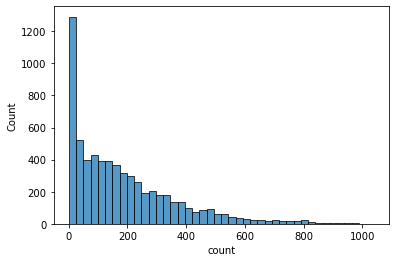

In [93]:
sns.histplot(result_['count'])

In [94]:
result_.to_csv('output_1014.csv', encoding = 'cp949', index = False)